# Conservative Q-Learning for Offline Reinforcement Learning

> Name: Ariana Koocheki Dariuni

> SID: 400103624



## Introduction
Conservative Q-Learning, CQL, aims to solve the overestimaion of values in offline RL algortihms by learning a conservative Q-function such that the expected value of a policy under this Q-function lower-bounds its true value.

## Preliminaries
#### **Notations**
* $T(s'|s,a)$ : The probability of $s\rightarrow a \rightarrow s'$
* $\mathcal{D}$ : the dataset of states sampled from $d^{\pi_{\beta}}(s)\pi_{\beta}$
* $r(s,a)$ : reward, $\gamma$ :discount factor
* ${\pi}_{\beta}(a|s)$ : behavior policy
* $\hat{\pi}_{\beta}(a|s)$ := $\frac{\sum_{s, a \in \mathcal{D}}1[s=s, a=a]}{\sum_{s, a \in \mathcal{D}}1[s=s]}$ : the empirical behavior policy
* $d^{\pi_{\beta}}(s)$ : the discount marginal state-distribution of $\pi_{\beta}(a|s)$
* $\mu (s,a)$ : a distribution of state-action pairs


#### **Assumptions**
* Assume the reward is bounded : $|r(s,a)| \leq R_\text{max}$


#### **Original Q-learning**
* Bellman operator

$$
\mathcal{B}^{\pi} Q = r + \gamma P^{\pi} Q, \quad
P^{\pi} Q(s,a) = \mathbb{E}_{s' \sim T(s'|s,a),\ a' \sim \pi(a'|s')} \left[ Q(s', a') \right]
$$

    
* train Q-function by iteratively applying **Bellman optimality operator**:

    $$\mathcal{B}^*Q(s,a) = r(s,a) + \gamma\mathbb{E}_{s'\sim P(s'|s,a)}[\max_{a'}Q(s',a')]$$
    
* The empirical Bellman operator $\hat{\mathcal{B}}^{\pi}$ only contains a single sample in $\mathcal{D}$.

    $$\hat{\mathcal{B}}^{\pi} \hat{Q}^k(s,a) = r(s,a) + \gamma \mathbb{E}_{a'\sim\hat{\pi}(a'|s')}[\hat Q^k(s',a')]$$

* Try to constrain $a'$ to stay close to behavior policy in Q-learning. In this case, it is able to avoid querying $Q$ on out-of-distribution(OOD) actions. Set a original Q-learning policy evaluation :

$$\hat{Q}^{k+1} \gets \arg\min_Q \mathbb{E}_{s,a,s'\sim D} \left[\left((r(s,a) + \gamma \mathbb{E}{a'\sim\hat{\pi}^k(a'|s')}[\hat{Q}^k(s',a')]) - Q(s,a)\right)^2\right]$$

* Original Q-learning policy improvement

$$
\hat{\pi}^{k+1} \gets \arg\max_\pi \mathbb{E}_{s \sim D, a \sim \pi^k(a|s)} \left[ \hat{Q}^{k+1}(s,a) \right]
$$


### Problems in Offline RL Algorithms
In practice, offline RL has encountered major challenge in offline RL is the distribution shift between the dataset and the learned policy, which can lead to ***overestimation*** of values for out-of-distribution actions.




## Conservative Q-Learning (CQL)
### Conservative Off-Policy Evaluation
* To be conservative, try to add penalty into the policy evaluation algorithm. The paper chose to restrict $\mu$, by letting $\mu(s,a) = d^{\pi_{\beta}}(s)\pi_{\beta}$. Simply view the $\color{yellow}{yellow}$ part as a penalty to push down $(\downarrow
)$ big Q-values:

$$
\hat{Q}^{k+1} \leftarrow {\arg\min}_{Q}\
\textcolor{yellow}{\alpha \mathbb{E}_{s \sim D, a \sim \mu(a|s)} [Q(s,a)]}
+ \frac{1}{2} \mathbb{E}_{s,a,s' \sim D} \left[ \left( Q(s,a) - \hat{B}^{\pi} \hat{Q}^k(s,a) \right)^2 \right]
\quad\quad (1)
$$

* It has been proved in *Theorem 3.1* of the paper that the Eq. (1) lower-bounds the true Q-function $Q^{\pi}$.

* The bound can be tightened if we only require the expected value of $\hat{Q}^{\pi}$ under the policy $\pi(a|s)$ and a lower bound on $V^{\pi}$. We can improve the bound by introducing an additional Q-value maximization term. In practice, adding the $\color{red}{red}$ term encourages an upward push $(\uparrow)$ on Q-values for $(s, a)$ samples from the dataset. Revise Eq. (1) as follows:

$$
\hat{Q}^{k+1} \leftarrow {\arg\min}_{Q}\
\alpha \left(
\mathbb{E}_{s \sim D, a \sim \mu(a|s)} [Q(s,a)]
{\color{red}{ - \mathbb{E}_{s \sim D, a \sim \hat{\pi}_{\beta}(a|s)} [Q(s,a)]}}
\right)
+ \frac{1}{2} \mathbb{E}_{s,a,s' \sim D} \left[ \left( Q(s,a) - \hat{B}^{\pi} \hat{Q}^k(s,a) \right)^2 \right]
\quad\quad (2)
$$


* It has been proved in *Theorem 3.2* of the paper that the Eq. (2) lower-bounds the expected value under the policy $\pi$, when $\mu = \pi$.
### Conservative Q-Learning for Offline RL
* With taking $\mu(s,a) = d^{\pi_{\beta}}(s)\pi_{\beta}$, since the policy $\hat{\pi}^k$ is derived from Q-function, we could instead choose $\mu(s,a)$ to approximate the policy that would maximize the current Q-function iterate.
* Denote $\text{CQL}(\mathcal{R})$ with a chosen regularizer $\mathcal{R}(\mu)$. In practice, adding the $\textcolor{lightgreen}{\text{green}}$ term enables us to find a closed-form solution for the inner maximization, bypassing the need to calculate (or optimize) it at each step:

$$
\min_Q \, \textcolor{lightgreen}{\max}_{\textcolor{lightgreen}{\mu}} \,
\alpha \left(
\mathbb{E}_{s \sim \mathcal{D}, a \sim \mu(a|s)} \left[ Q(s, a) \right]
-
\mathbb{E}_{s \sim \mathcal{D}, a \sim \hat{\pi}_\beta(a|s)} \left[ Q(s, a) \right]
\right)
+ \frac{1}{2} \mathbb{E}_{s, a, s' \sim \mathcal{D}} \left[ \left( Q(s, a) - \hat{\mathcal{B}}^{\pi_k} \hat{Q}^k(s, a) \right)^2 \right]
+ \textcolor{lightgreen}{\mathcal{R}(\mu)}
\quad \left( \text{CQL}(\mathcal{R}) \right) \quad\quad (3)
$$


* "conservative" indicates the sense that each successive policy iterate is optimized against a lower bound on its value. $\text{CQL}$ is say to be conservative by showing that $\text{CQL}(\mathcal H)$ learns Q-value estimates that lower-bound the actual Q-function. It has been proved in *Theorem 3.3* that $\text{CQL}$ learns lower-bounded Q-values with large enough $\alpha$, meaning that the final policy attains the estimated value.

* The paper also shows that $\text{CQL}$ optimizes a well-defined, penalized empirical RL objective, and performs high-confidence safe policy improvement over the behavior policy.

### Regulizer and Variant of CQL

* The paper provides several variants of CQL based on different regularizers. One of the most common is $\text{CQL}(\mathcal{H})$, which corresponds to maximum entropy regularization. (The disscussion of CQL variants is in Appendices P.14). By replacing the optimal closed-form solution of the inner maximization with $\mu^{*}$, the final objective of $\text{CQL}(\mathcal{H})$ is as follows:
    $$
    \text{CQL}(\mathcal H) := \min_Q \ \alpha \mathbb{E}_{s \sim \mathcal{D}} \left[ \log \sum_a \exp(Q(s, a)) - \mathbb{E}_{a \sim \hat{\pi}_\beta(a|s)} \left[ Q(s, a) \right] \right] + \frac{1}{2} \mathbb{E}_{s, a, s' \sim \mathcal{D}} \left[ \left( Q - \hat{\mathcal{B}}^{\pi_k} \hat{Q}^k \right)^2 \right] \quad\quad (4)
    $$

* Another approach: choose ${\mathcal{R} (\mu)}$ to be the KL-divergence against a prior distribution $\rho (a|s)$, i.e. $\mathcal{R}(\mu) = -D_{KL}(\mu, \rho)$.

Show the derivation of Eq. (4).

**Answer (I)**:
To derive Equation (4), we focus on the inner maximization problem in Equation (3) when $\mathcal{R}(\mu)$ is the negative entropy of $\mu$, i.e., $\mathcal{R}(\mu) = -\mathcal{H}(\mu) = \mathbb{E}_{s \sim \mathcal{D}, a \sim \mu(a|s)} [\log \mu(a|s)]$.

The inner maximization problem is:
$$ \max_{\mu} \left( \alpha \mathbb{E}_{s \sim \mathcal{D}, a \sim \mu(a|s)} \left[ Q(s, a) \right] + \mathcal{R}(\mu) \right) $$
Substituting $\mathcal{R}(\mu) = -\mathbb{E}_{s \sim \mathcal{D}, a \sim \mu(a|s)} [\log \mu(a|s)]$, we get:
$$ \max_{\mu} \mathbb{E}_{s \sim \mathcal{D}} \left[ \sum_a \mu(a|s) \left( \alpha Q(s, a) - \log \mu(a|s) \right) \right] $$
For a fixed state $s$, we aim to maximize $\sum_a \mu(a|s) \left( \alpha Q(s, a) - \log \mu(a|s) \right)$ subject to $\sum_a \mu(a|s) = 1$ and $\mu(a|s) \ge 0$. Using Lagrange multipliers, the optimal $\mu^*(a|s)$ is found to be the softmax distribution:
$$ \mu^*(a|s) = \frac{\exp(\alpha Q(s, a))}{\sum_{a'} \exp(\alpha Q(s, a'))} $$
Now, we substitute this optimal $\mu^*(a|s)$ back into the inner maximization objective.
The term $\log \mu^*(a|s)$ is:
$$ \log \mu^*(a|s) = \alpha Q(s, a) - \log \left( \sum_{a'} \exp(\alpha Q(s, a')) \right) $$
Substitute this back into the sum for a fixed state $s$:
$$ \sum_a \mu^*(a|s) \left( \alpha Q(s, a) - \left( \alpha Q(s, a) - \log \left( \sum_{a'} \exp(\alpha Q(s, a')) \right) \right) \right) $$
$$ = \sum_a \mu^*(a|s) \left( \log \left( \sum_{a'} \exp(\alpha Q(s, a')) \right) \right) $$
Since $\sum_a \mu^*(a|s) = 1$, this simplifies to:
$$ \log \left( \sum_a \exp(\alpha Q(s, a)) \right) $$
Therefore, the result of the inner maximization averaged over states $s \sim \mathcal{D}$ is:
$$ \mathbb{E}_{s \sim \mathcal{D}} \left[ \log \left( \sum_a \exp(\alpha Q(s, a)) \right) \right] $$
Finally, substitute this result back into the full $\text{CQL}(\mathcal{R})$ objective (Equation 3). Assuming the $\alpha$ is factored out as in Equation (4), and the optimal $\mu$ corresponds to the given form:
$$
\min_Q \ \alpha \left( \mathbb{E}_{s \sim \mathcal{D}} \left[ \log \sum_a \exp(Q(s, a)) \right] - \mathbb{E}_{s \sim \mathcal{D}, a \sim \hat{\pi}_\beta(a|s)} \left[ Q(s, a) \right] \right) + \frac{1}{2} \mathbb{E}_{s, a, s' \sim \mathcal{D}} \left[ \left( Q(s, a) - \hat{\mathcal{B}}^{\pi_k} \hat{Q}^k(s, a) \right)^2 \right]
$$
This matches Equation (4), where the factor of $\alpha$ in front of the $\log \sum_a \exp(Q(s,a))$ term in the original derivation is absorbed by re-scaling the $Q(s,a)$ inside the exponent, or is explicitly factored out as a global coefficient for the combined penalty terms, assuming the maximum entropy term is formulated such that $\alpha$ scales the resulting free energy.

---
# Implementation

Now, you are required to implement a `CQL-SAC` training pipeline on the `Pendulum` environment. To validate your implementation, you should:

- Plot the training reward of your agent, highlighting its convergence (the reward should steadily increase).
- Compare the performance of the trained agent with that of a randomly initialized agent over several validation trajectories.


#### **Imports**

In [1]:
import os
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import numpy as np
import math
import copy
from torch.distributions import Normal
import gym
import numpy as np
from collections import deque
import torch
import argparse
import random
import numpy as np
np.bool8 = np.bool_

import random
import torch
from collections import deque, namedtuple

#### **Some Useful Functions**

In [2]:
##############################################
# no need to do any thing,
# However, you can change it if needed
##############################################

def save(args, save_name, model, wandb, ep=None):
    import os
    save_dir = './trained_models/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not ep == None:
        torch.save(model.state_dict(), save_dir + args.run_name + save_name + str(ep) + ".pth")
        wandb.save(save_dir + args.run_name + save_name + str(ep) + ".pth")
    else:
        torch.save(model.state_dict(), save_dir + args.run_name + save_name + ".pth")
        wandb.save(save_dir + args.run_name + save_name + ".pth")

def collect_random(env, dataset, num_samples=200):
    state = env.reset()
    for _ in range(num_samples):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)

        dataset.add(state, action, reward, next_state, done)
        state = next_state
        if done:
            state = env.reset()

def evaluate(env, policy, eval_runs=5):
    """
    Makes an evaluation run with the current policy
    """
    reward_batch = []
    for i in range(eval_runs):
        state = env.reset()

        rewards = 0
        while True:
            action = policy.get_action(state, eval=True)
            next_state, reward, done, info = env.step(action)

            rewards += reward
            if done:
                break
        reward_batch.append(rewards)
    return np.mean(reward_batch)

#### **Replay Buffer**

In [3]:
##############################################
# no need to do any thing,
# However, you can change it if needed
##############################################

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


#### **(Soft) Actor \& Critic**

In [9]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, hidden_size=256, init_w=3e-3, log_std_min=-20, log_std_max=2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            hidden_size (int): Number of nodes in the hidden layers
            init_w (float): Initial weight for the final layer
            log_std_min (float): Minimum value for log standard deviation
            log_std_max (float): Maximum value for log standard deviation
        """
        super(Actor, self).__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        # Define a 2-layer MLP as a shared backbone
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        # Define mu and log_std heads
        self.mu = nn.Linear(hidden_size, action_size)
        self.log_std_linear = nn.Linear(hidden_size, action_size)

        # Initialize weights for the final layers
        self.mu.weight.data.uniform_(-init_w, init_w)
        self.mu.bias.data.uniform_(-init_w, init_w)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)


    def forward(self, state):
        """Build an actor (policy) network that maps states -> (mu, log_std)."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        mu = self.mu(x)
        log_std = self.log_std_linear(x)

        # Clip log_std to ensure numerical stability and reasonable action scales
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)

        return mu, log_std

    def evaluate(self, state, epsilon=1e-6):
        """
        Evaluates the action and its log probability for a given state.
        This method is used during policy evaluation for training.
        """
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)

        # Sample from the reparameterized Gaussian distribution
        # e is a sample from N(mu, std)
        e = dist.rsample().to(state.device)

        # Apply tanh squashing to get the action in the [-1, 1] range
        action = torch.tanh(e)

        # Calculate the log probability of the action
        # This involves correcting the Gaussian log-probability by applying the
        # change-of-variable formula for tanh-squashed actions.
        # It adjusts the Gaussian log-probability with the log-Jacobian determinant
        # to account for the squashing transformation.
        log_prob = (dist.log_prob(e) - torch.log(1 - action.pow(2) + epsilon)).sum(1, keepdim=True)

        return action, log_prob


    def get_action(self, state):
        """
        Returns an action based on a squashed Gaussian policy.
        The samples are obtained according to: a(s,e) = tanh(mu(s) + sigma(s) * e_sample)
        This method is typically used for sampling actions during exploration.
        """
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)

        # Sample from the reparameterized Gaussian distribution
        e = dist.rsample().to(state.device)

        # Apply tanh squashing to get the action
        action = torch.tanh(e)

        # Detach from the computation graph and move to CPU for inference
        return action.detach().cpu()

    def get_det_action(self, state):
        """
        Returns a deterministic action for a given state.
        This is typically used during evaluation or deployment, where exploration is not needed.
        """
        # During the inference phase, we don't need the 'std'; treat it deterministically.
        mu, log_std = self.forward(state) # log_std is computed but not used for deterministic action
        return torch.tanh(mu).detach().cpu()


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, hidden_size=256, seed=1):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (int): Number of nodes in the network layers
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        # Input layer concatenates state and action
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)

        # Define the rest of the network layers
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1) # Output a single Q-value

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        # Concatenate state and action tensors
        x = torch.cat((state, action), dim=-1)

        # Pass through the network layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output the Q-value
        return self.fc3(x)


In [10]:

class CQLSAC(nn.Module):
    """Interacts with and learns from the environment."""

    def __init__(self,
                 state_size,
                 action_size,
                 tau,
                 hidden_size,
                 learning_rate,
                 temp,
                 cql_weight,
                 target_action_gap,
                 device
                ):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            tau (float): interpolation parameter for soft update
            hidden_size (int): Number of nodes in the network layers
            learning_rate (float): Learning rate for optimizers
            temp (float): Temperature parameter for CQL log-sum-exp
            cql_weight (float): Weight for the CQL regularization term
            target_action_gap (float): Target value for the CQL alpha auto-tuning
            device (torch.device): Device to run computations on (CPU/GPU)
        """
        super(CQLSAC, self).__init__()
        self.state_size = state_size
        self.action_size = action_size

        self.device = device

        self.gamma = torch.FloatTensor([0.99]).to(device)
        self.tau = tau
        self.hidden_size = hidden_size # Store hidden_size
        self.learning_rate = learning_rate # Store learning_rate
        self.clip_grad_param = 1

        self.target_entropy = -action_size  # -dim(A)

        # Initialize log_alpha directly on the specified device
        self.log_alpha = torch.tensor([0.0], requires_grad=True, device=device)
        self.alpha = self.log_alpha.exp().detach()
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=learning_rate)

        # CQL params
        self.temp = temp
        self.cql_weight = cql_weight
        self.target_action_gap = target_action_gap
        # Initialize cql_log_alpha directly on the specified device
        self.cql_log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.cql_alpha_optimizer = optim.Adam(params=[self.cql_log_alpha], lr=learning_rate)

        # Actor Network
        self.actor_local = Actor(state_size, action_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=learning_rate)

        # Critic Network (w/ Target Network)
        self.critic1 = Critic(state_size, action_size, hidden_size, 2).to(device)
        self.critic2 = Critic(state_size, action_size, hidden_size, 1).to(device)

        assert self.critic1.parameters() != self.critic2.parameters()

        self.critic1_target = Critic(state_size, action_size, hidden_size).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())

        self.critic2_target = Critic(state_size, action_size, hidden_size).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=learning_rate)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=learning_rate)


    def get_action(self, state, eval=False):
        """Returns actions for given state as per current policy."""
        state = torch.tensor(state, dtype=torch.float32).to(self.device)

        # Implement action selection using the policy. Use eval mode for deterministic actions.
        if eval:
            action = self.actor_local.get_det_action(state)
        else:
            action = self.actor_local.get_action(state)

        return action.numpy()

    def calc_policy_loss(self, states, alpha):
        """
        Calculates the policy (actor) loss.

        NOTE: We use two critics (Double Q-Learning) to mitigate overestimation bias
        in Q-value estimates, which reduces variance and improves the stability
        of training. Taking the minimum of the two critics provides a more reliable
        estimate of the expected return, preventing overly optimistic value targets.
        """
        actions_pred, log_pis = self.actor_local.evaluate(states)

        q1 = self.critic1(states, actions_pred.squeeze(0))
        q2 = self.critic2(states, actions_pred.squeeze(0))
        # Ensure min_Q is on the correct device for subsequent operations
        min_Q = torch.min(q1, q2)

        # compute actor loss: J_pi = E_s,a~pi [alpha * log_pi(a|s) - Q(s,a)]
        # Ensure all tensors are on the same device before operations
        actor_loss = (alpha * log_pis - min_Q).mean()
        return actor_loss, log_pis

    def _compute_policy_values(self, obs_pi, obs_q):
        """
        Computes the policy values adjusted by the policy's entropy term.

        Args:
            obs_pi (torch.Tensor): Observations for the policy network (actor).
            obs_q (torch.Tensor): Observations for the critic network (Q-function).

        Returns:
            tuple: (Adjusted Q1 values, Adjusted Q2 values) where each Q-value is penalized
            by the log probability of the action to encourage exploration via entropy regularization.
        """
        actions_pred, log_pis = self.actor_local.evaluate(obs_pi)

        qs1 = self.critic1(obs_q, actions_pred)
        qs2 = self.critic2(obs_q, actions_pred)

        return qs1 - log_pis.detach(), qs2 - log_pis.detach()


    def _compute_random_values(self, obs, actions, critic):
        """
        Computes Q-values for random actions with a fixed uniform log-probability adjustment.

        Args:
            obs (torch.Tensor): Observations for the critic network.
            actions (torch.Tensor): Random actions sampled uniformly.
            critic (nn.Module): The critic network (Q-function).

        Returns:
            torch.Tensor: Adjusted Q-values penalized by the fixed log-probability of random actions.
            This simulates the behavior of uniformly random policies.
        """
        random_values = critic(obs, actions)
        # For uniform distribution over [-1, 1], the density is 1/2.
        # For action_size dimensions, the joint density is (1/2)^action_size.
        # Log probability is log((1/2)^action_size) = action_size * log(0.5)
        random_log_probs = math.log(0.5 ** self.action_size)
        # Ensure random_log_probs is a tensor on the correct device
        random_log_probs_tensor = torch.tensor(random_log_probs, device=obs.device)
        return random_values - random_log_probs_tensor


    def learn(self, experiences):
        """Updates actor, critics and entropy_alpha parameters using given batch of experience tuples.
        Q_targets = r + γ * (min_critic_target(next_state, actor_target(next_state)) - α *log_pi(next_action|next_state))
        Critic_loss = MSE(Q, Q_target)
        Actor_loss = α * log_pi(a|s) - Q(s,a)
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
        """
        states, actions, rewards, next_states, dones = experiences

        # Ensure tensors are on the correct device
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        # ---------------------------- update actor ---------------------------- #
        current_alpha = copy.deepcopy(self.alpha)

        # Calculate the actor loss using current policy and alpha
        actor_loss, log_pis = self.calc_policy_loss(states, current_alpha)

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        clip_grad_norm_(self.actor_local.parameters(), self.clip_grad_param)
        self.actor_optimizer.step()

        # Compute alpha loss (for entropy regularization)
        # Ensure all tensors are on the same device for this calculation
        alpha_loss = - (self.log_alpha.exp() * (log_pis + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp().detach()

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        with torch.no_grad():
            next_action, new_log_pi = self.actor_local.evaluate(next_states)
            Q_target1_next = self.critic1_target(next_states, next_action)
            Q_target2_next = self.critic2_target(next_states, next_action)

            # Compute Q_target_next: min of target Q-values minus alpha * entropy
            Q_target_next = torch.min(Q_target1_next, Q_target2_next) - self.alpha * new_log_pi

            # Now, using Q_target_next compute Q targets for current states (y_i)
            # Q_targets = r + γ * (1 - done) * Q_target_next
            Q_targets = rewards + (self.gamma * Q_target_next * (1 - dones))


        # Compute critic loss. Hint: use 'F.mse_loss' to compute critic losses.
        q1 = self.critic1(states, actions)
        q2 = self.critic2(states, actions)

        critic1_loss = F.mse_loss(q1, Q_targets.detach())
        critic2_loss = F.mse_loss(q2, Q_targets.detach())

        # ------------------------ CQL Addon ------------------------ #
        # Sample random actions uniformly from the action space
        # It's common to sample more random actions than batch size for better estimation
        random_actions = torch.FloatTensor(q1.shape[0] * 10, actions.shape[-1]).uniform_(-1, 1).to(self.device)

        # Repeat states and next_states to match the number of random actions
        num_repeat = int(random_actions.shape[0] / states.shape[0])
        temp_states = states.unsqueeze(1).repeat(1, num_repeat, 1).view(states.shape[0] * num_repeat, states.shape[1])
        temp_next_states = next_states.unsqueeze(1).repeat(1, num_repeat, 1).view(next_states.shape[0] * num_repeat, next_states.shape[1])

        # Compute Q-values for actions sampled from the current policy (current states and next states)
        current_pi_values1, current_pi_values2 = self._compute_policy_values(temp_states, temp_states)
        next_pi_values1, next_pi_values2 = self._compute_policy_values(temp_next_states, temp_states)

        # Compute Q-values for random actions (baseline uniform actions)
        random_values1 = self._compute_random_values(temp_states, random_actions, self.critic1).reshape(states.shape[0], num_repeat, 1)
        random_values2 = self._compute_random_values(temp_states, random_actions, self.critic2).reshape(states.shape[0], num_repeat, 1)

        # Reshape the current and next policy values to group per state
        current_pi_values1 = current_pi_values1.reshape(states.shape[0], num_repeat, 1)
        current_pi_values2 = current_pi_values2.reshape(states.shape[0], num_repeat, 1)
        next_pi_values1 = next_pi_values1.reshape(states.shape[0], num_repeat, 1)
        next_pi_values2 = next_pi_values2.reshape(states.shape[0], num_repeat, 1)

        # Concatenate random, current, and next policy Q-values for log-sum-exp computation
        cat_q1 = torch.cat([random_values1, current_pi_values1, next_pi_values1], 1)
        cat_q2 = torch.cat([random_values2, current_pi_values2, next_pi_values2], 1)

        # Sanity check: ensure shapes are correct
        assert cat_q1.shape == (states.shape[0], 3 * num_repeat, 1), f"cat_q1 instead has shape: {cat_q1.shape}"
        assert cat_q2.shape == (states.shape[0], 3 * num_repeat, 1), f"cat_q2 instead has shape: {cat_q2.shape}"

        # Compute the CQL regularization loss using log-sum-exp to penalize Q-values
        # The equation for CQL loss is:
        # alpha * (log_sum_exp(Q(s, a_i) / temp) - Q(s, a_data))
        # where a_i includes random actions, current policy actions, and next policy actions.
        # The paper uses a slightly different form where the Q(s, a_data) term is subtracted
        # and then the whole expression is scaled by cql_weight and temp.
        # Here, it's implemented as: (logsumexp(cat_q / temp) * temp) - q_data.mean()
        # and then scaled by cql_weight.
        cql1_scaled_loss = ((torch.logsumexp(cat_q1 / self.temp, dim=1).mean() * self.temp) - q1.mean()) * self.cql_weight
        cql2_scaled_loss = ((torch.logsumexp(cat_q2 / self.temp, dim=1).mean() * self.temp) - q2.mean()) * self.cql_weight

        # Adaptive CQL alpha (optional in advanced CQL versions)
        # This part implements the auto-tuning of the CQL alpha parameter,
        # which balances the conservatism.
        # Initialize on device
        cql_alpha_loss = torch.tensor([0.0], device=self.device)
        cql_alpha = torch.tensor([0.0], device=self.device)

        # Only update cql_alpha if cql_weight > 0 and target_action_gap is set
        if self.cql_weight > 0 and self.target_action_gap is not None:
            # The target_action_gap is used to encourage the difference between
            # the log-sum-exp of Q-values and the Q-value of the data actions
            # to be close to a target value.
            cql_alpha_loss = (self.cql_log_alpha.exp() * (cql1_scaled_loss - self.cql_weight * self.target_action_gap).detach()).mean()
            self.cql_alpha_optimizer.zero_grad()
            cql_alpha_loss.backward()
            self.cql_alpha_optimizer.step()
            cql_alpha = self.cql_log_alpha.exp().detach()


        # Combine critic losses with CQL regularization
        total_c1_loss = critic1_loss + cql1_scaled_loss
        total_c2_loss = critic2_loss + cql2_scaled_loss


        # Update critics
        # critic 1
        self.critic1_optimizer.zero_grad()
        total_c1_loss.backward(retain_graph=True)
        clip_grad_norm_(self.critic1.parameters(), self.clip_grad_param)
        self.critic1_optimizer.step()

        # critic 2
        self.critic2_optimizer.zero_grad()
        total_c2_loss.backward()
        clip_grad_norm_(self.critic2.parameters(), self.clip_grad_param)
        self.critic2_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        # Update self.critic1_target & self.critic2_target using self.critic1 & 2 (and soft_update function:).
        self.soft_update(self.critic1, self.critic1_target)
        self.soft_update(self.critic2, self.critic2_target)

        return actor_loss.item(), alpha_loss.item(), critic1_loss.item(), critic2_loss.item(), cql1_scaled_loss.item(), cql2_scaled_loss.item(), current_alpha.item(), cql_alpha_loss.item(), cql_alpha.item()

    def soft_update(self, local_model , target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)


In [11]:
def get_config():
    parser = argparse.ArgumentParser(description='RL')
    parser.add_argument("--run_name", type=str, default="CQL-SAC", help="Run name, default: CQL-SAC")
    parser.add_argument("--env", type=str, default="Pendulum-v1", help="Gym environment name, default: Pendulum-v0")
    parser.add_argument("--episodes", type=int, default=200, help="Number of episodes, default: 200")
    parser.add_argument("--buffer_size", type=int, default=100_000, help="Maximal training dataset size, default: 100_000")
    parser.add_argument("--seed", type=int, default=1, help="Seed, default: 1")
    parser.add_argument("--log_video", type=int, default=0, help="Log agent behaviour to wanbd when set to 1, default: 0")
    parser.add_argument("--save_every", type=int, default=100, help="Saves the network every x epochs, default: 25")
    parser.add_argument("--batch_size", type=int, default=256, help="Batch size, default: 256")
    parser.add_argument("--hidden_size", type=int, default=256, help="")
    parser.add_argument("--learning_rate", type=float, default=3e-4, help="")
    parser.add_argument("--temperature", type=float, default=1.0, help="")
    parser.add_argument("--cql_weight", type=float, default=1.0, help="")
    parser.add_argument("--target_action_gap", type=float, default=10, help="")
    parser.add_argument("--tau", type=float, default=5e-3, help="")

    args = parser.parse_args()
    return args

In [12]:
##############################################
# no need to do any thing,
# However, you can change it if needed
##############################################

import matplotlib.pyplot as plt
import numpy as np
import random
import os
import torch
from collections import deque

def train(config):
    np.random.seed(config.seed)
    random.seed(config.seed)
    torch.manual_seed(config.seed)

    env = gym.make(config.env)
    eval_env = gym.make(config.env)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    steps = 0
    average10 = deque(maxlen=10)
    total_steps = 0

    agent = CQLSAC(
        state_size=env.observation_space.shape[0],
        action_size=env.action_space.shape[0],
        tau=config.tau,
        hidden_size=config.hidden_size,
        learning_rate=config.learning_rate,
        temp=config.temperature,
        cql_weight=config.cql_weight,
        target_action_gap=config.target_action_gap,
        device=device
    )

    buffer = ReplayBuffer(buffer_size=config.buffer_size, batch_size=config.batch_size, device=device)

    collect_random(env=env, dataset=buffer, num_samples=10000)

    eval_reward = evaluate(eval_env, agent)
    print(f"Initial Test Reward: {eval_reward:.2f}")
    print('-' * 50)

    rewards_history = []    # Store per episode reward
    average10_history = []  # Store moving average

    for i in range(1, config.episodes + 1):
        state = env.reset()
        episode_steps = 0
        rewards = 0
        done = False
        while not done:
            action = agent.get_action(state)
            steps += 1

            next_state, reward, done, info = env.step(action)

            buffer.add(state, action, reward, next_state, done)
            policy_loss, alpha_loss, bellmann_error1, bellmann_error2, cql1_loss, cql2_loss, current_alpha, lagrange_alpha_loss, lagrange_alpha = agent.learn(buffer.sample())
            state = next_state
            rewards += reward
            episode_steps += 1

        average10.append(rewards)
        rewards_history.append(rewards)
        average10_history.append(np.mean(average10))
        total_steps += episode_steps
        print(f"Episode: {i} | Reward: {rewards:.2f} | Average10: {np.mean(average10):.2f} | Steps: {steps}")

        if i % config.save_every == 0:
            save_dir = './trained_models/'
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            torch.save(agent.actor_local.state_dict(), save_dir + config.run_name + "_CQL-DQN_" + str(i) + ".pth")
            print(f"Model saved at episode {i}")

    # Plot Reward and Average10
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    axs[0].plot(rewards_history, label='Reward per Episode')
    axs[0].set_title('Reward per Episode')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(average10_history, label='Average Reward (10 episodes)', color='orange')
    axs[1].set_title('Moving Average Reward (10 episodes)')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Average Reward')
    axs[1].legend()
    axs[1].grid()

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Initial Test Reward: -1281.58
--------------------------------------------------
Episode: 1 | Reward: -859.03 | Average10: -859.03 | Steps: 200
Episode: 2 | Reward: -920.26 | Average10: -889.65 | Steps: 400
Episode: 3 | Reward: -1554.76 | Average10: -1111.35 | Steps: 600
Episode: 4 | Reward: -1361.12 | Average10: -1173.79 | Steps: 800
Episode: 5 | Reward: -1649.16 | Average10: -1268.87 | Steps: 1000
Episode: 6 | Reward: -961.93 | Average10: -1217.71 | Steps: 1200
Episode: 7 | Reward: -1448.63 | Average10: -1250.70 | Steps: 1400
Episode: 8 | Reward: -1465.47 | Average10: -1277.54 | Steps: 1600
Episode: 9 | Reward: -1367.21 | Average10: -1287.51 | Steps: 1800
Episode: 10 | Reward: -917.27 | Average10: -1250.48 | Steps: 2000
Episode: 11 | Reward: -871.49 | Average10: -1251.73 | Steps: 2200
Episode: 12 | Reward: -1268.38 | Average10: -1286.54 | Steps: 2400
Episode: 13 | Reward: -497.27 | Average10: -1180.79 | Steps: 2600
Episode: 14 | Reward: -740.36 | Average10: -1118.72 | Steps: 2800
Epi

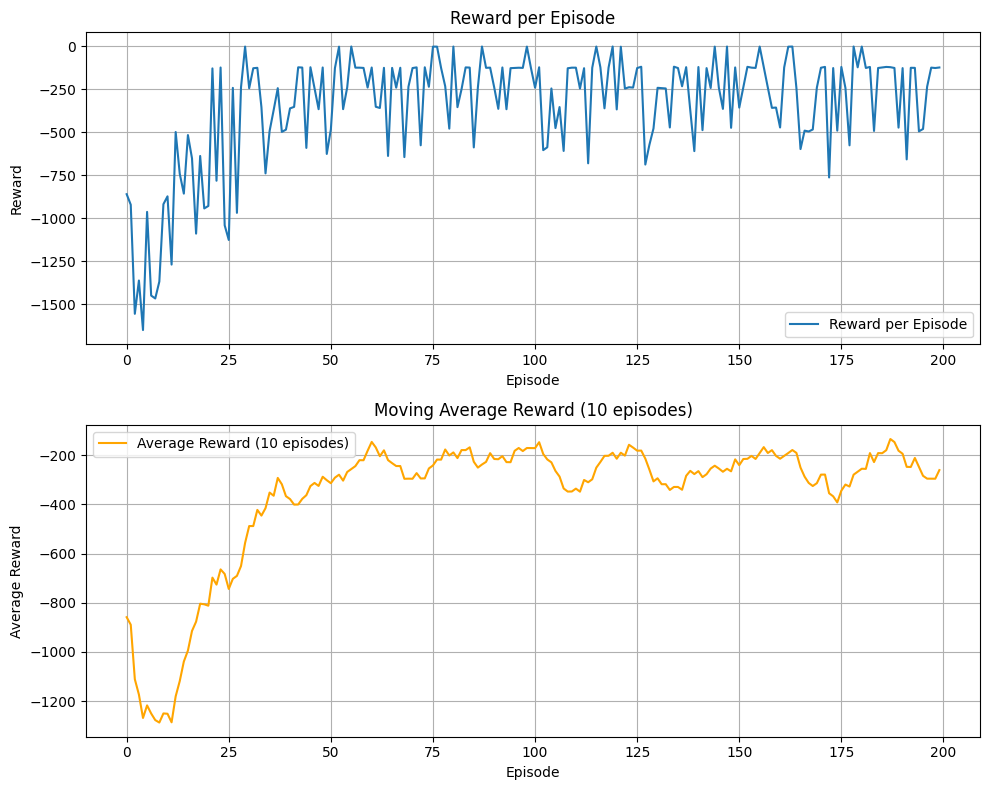

In [13]:
##############################################
# no need to do any thing,
# However, you can change it if needed
##############################################

import sys
sys.argv=['']
del sys
config = get_config()
train(config)

## Conclusion:

In this assignment, we trained a SAC agent using a relatively large offline dataset collected from a random policy, supplemented by a limited number of online interactions gathered during training. These online samples were used both for training and for evaluating the agent’s performance in newly observed states, highlighting improvements over time. While this hybrid setup enabled effective learning, it is important to note that in real-world offline RL scenarios, online interactions are often prohibited, making the problem significantly more challenging. In such cases, greater amounts of offline data and longer training periods are necessary. Through this process, we gained a deeper understanding of the intuition behind Conservative Q-Learning (CQL), its practical implementation, and why it is considered a stable and popular method for offline reinforcement learning.

# ***Best Regards.***